In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batting = pd.read_csv('../dataset/Batting.csv')
df_pitching = pd.read_csv('../dataset/Pitching.csv')
df_fielding = pd.read_csv('../dataset/Fielding.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
df_teams = pd.read_csv('../dataset/Teams.csv')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

Advanced Model

In [198]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']

In [199]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [200]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [201]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

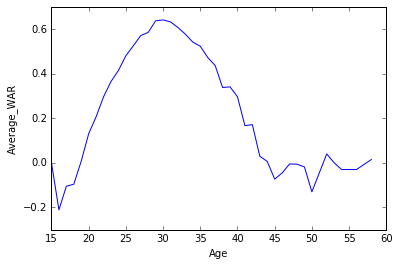

In [17]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [202]:
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [203]:
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                tempDict = player_performance_projection(row['player'],age)
                for i in range(1,16):
                    if i in valDict.keys():
                        valDict[i] += tempDict[i]
                    else:
                        valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [204]:
import scipy.optimize as optimize
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [205]:
trade_val_projection_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

In [206]:
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [207]:
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return (ret)

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],act))

In [208]:
#import pickle
#with open("diff_list_2.pkl", "rb") as input_file:
 #   diff_list = pickle.load(input_file)
#diff_list = pickle.load( open( "diff_list.pkl", "rb" ) )

In [209]:
#diff_list

In [210]:
sList = sorted(diff_list,key=lambda x: x[1], reverse=True)

In [211]:
rank_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for i in sList:
    tranID = i[0]
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    rank_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,i[1]]
    k += 1
    #if (k == 100):
     #   break

In [47]:
rank_df

,Rank,Date,Team1,Team2,Players Team1,Player Team2,Trade Value Diff
0,1.0,1949-12-14,NY1,BSN,"Sid Gordon,Buddy Kerr,Willard Marshall,Red Webb","Eddie Stanky,Al Dark",8.103336
1,2.0,1959-12-06,CLE,CHA,"Minnie Minoso,Dick Brown,Don Ferrarese,Jake St...","John Romano,Bubba Phillips,Norm Cash",7.831614
2,3.0,1963-01-14,BAL,CHA,"Hoyt Wilhelm,Dave Nicholson,Pete Ward,Ron Hansen","Luis Aparicio,Al Smith",7.402284
3,4.0,1959-12-11,NYA,KC1,"Don Larsen,Hank Bauer,Norm Siebern,Marv Throne...","Roger Maris,Joe DeMaestri,Kent Hadley",7.368413
4,5.0,1946-09-30,PIT,BSN,"Bob Elliott,Hank Camelli","Billy Herman,Elmer Singleton,Stan Wentzel,Whit...",7.213203
5,6.0,1999-12-22,SDN,ATL,"Wally Joyner,Reggie Sanders,Quilvio Veras","Bret Boone,Ryan Klesko,Jason Shiell",7.159809
6,7.0,1904-12-26,BOS,SLA,",George Stone",Jesse Burkett,7.092150
7,8.0,1928-10-29,NY1,PHI,",Lefty O'Doul",Freddy Leach,6.990570
8,9.0,1997-11-18,TBA,PHI,Bobby Abreu,Kevin Stocker,6.815524
9,10.0,1928-11-07,CHN,BSN,",Socks Seibold,Percy Jones,Lou Legett,Freddie ...",Rogers Hornsby,6.604151


In [212]:
#val_diff = pd.DataFrame(diff_list, columns=["TranID", "Trade_Value_Diff"])
tdiffDict = {}
for i in sList:
    tdiffDict[i[0]] = i[1]

In [213]:
df_sort = df_tran.sort(['transaction-ID'])
no_of_trade = pd.DataFrame(columns = ['Year','PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'] )
#no_of_trade = no_of_trade.set_index(['Year'])
#no_of_trade=no_of_trade.fillna(0.0, inplace=True)
td = df_sort['transaction-ID'].unique()
year = df_sort['tranYear'].unique()
no_of_trade['Year'] = year
no_of_trade=no_of_trade.fillna(0)
for x in range(0, len(td)):
    tran_id = df_sort[df_sort['transaction-ID']==td[x]].iloc[0]
    yr = no_of_trade[no_of_trade['Year'] == tran_id['tranYear']].iloc[0]
    yr[tran_id['from-team']] = yr[tran_id['from-team']] + 1;
    no_of_trade[tran_id['from-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['from-team']]
    yr[tran_id['to-team']] = yr[tran_id['to-team']] + 1;
    no_of_trade[tran_id['to-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['to-team']]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [ ]:
#Calculates various params for each trade
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    year = td['tranYear'].iloc[0]
    player_vals = [] #To calculate player val diff
    num_players = [] #To calculate diff of number of players involved
    num_trades = [] #To calculate number of trades each side players were involved in before the trade
    num_trades_team = [] #To calculate number of trades each team did in this year
    ages = [] #Average ages of the two sides
    ranks = []
    for x in teams:
        #print x
        val = 0 #for player_vals[]
        num = 0 #for num_players[]
        age = 0 #for ages[]
        num_tr = 0 # for num_trades[]
        
        t_ranks = df_teams[(df_teams['teamIDretro'] == x)]
        t_rank = t_ranks[(t_ranks['yearID'] == year)]
        if not t_rank.empty:
            rank = t_rank['Rank'].iloc[0]
        else:
            rank = 7
            
        num_tr_team = no_of_trade[x][no_of_trade['Year']==year].iloc[0]
        
        for index, row in td.iterrows():
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                num += 1
                #year = int(row['tranYear'])
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                
                trades = df_tran[(df_tran['player'] == row['player'])]
                trades_before = trades[(trades['tranYear'] < row['tranYear'])]
                num_tr += len(trades_before)
                
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                    age += player_df_year['age'].iloc[0]
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year
                    val += float(player_df['WAR'].iloc[0])
                    age += player_df['age'].iloc[0]
                else:
                    ## figure out a way to find war for these players
                    val += 0
        num_players.append(num)
        num_trades.append(num_tr)
        num_trades_team.append(num_tr_team)
        player_vals.append(val)
        ranks.append(rank)
        if(num==0):
            print "Zero player involved for:",tranID
            num = 1
        ages.append(float(age/num))
        v_diff = tdiffDict[tranID]
    #return (abs(player_vals[0]-player_vals[1]),tranID,abs(num_players[0]-num_players[1]),year,abs(ages[0]-ages[1]),v_diff)
    return (tranID,year,teams[0],teams[1],v_diff,player_vals[0],player_vals[1],num_players[0],num_players[1],ages[0],ages[1],num_trades[0],num_trades[1],ranks[0],ranks[1],num_trades_team[0],num_trades_team[1])

trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Zero player involved for: 57916


In [195]:
print trade_value_old(72232,'WAR')
#df_tran[(df_tran['transaction-ID'] == 48244)]
#df_tran[(df_tran['transaction-ID'] == 57916)]
#df_tran[(df_tran['transaction-ID'] == 72232)]
#df_tran.head()
#df_teams.head()

DET
HOU
(72232, 1968, 'DET', 'HOU', 0.099838831263362821, -0.29, 0.88, 2, 1, 27.5, 35.0, 0, 1, 1, 10, 4, 10)


/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [55]:
#player_df = df_batstat[(df_batstat['retroID'] == 'keelw101')]
#player_df_year = player_df[(df_batstat['year_ID'] == 1894)]
#player_df_year

In [ ]:
#df_war_diff = pd.DataFrame(trade_val_list_WAR_old, columns=["WAR_Diff","TranID","Num_Players","Year","Age_Diff","Project"])
#val_diff = pd.DataFrame(diff_list, columns=["TranID", "Trade_Value_Diff"])
df_features = pd.DataFrame(trade_val_list_WAR_old, columns=["TranID","Year","Team_1","Team_2","Projected_Diff","WAR_Sum_1","WAR_Sum_2","Num_Pl_1","Num_Pl_2","Avg_Age_1","Avg_Age_2","Num_Trades_Pl_1","Num_Trades_Pl_2","Rank_1","Rank_2","Num_Trades_T_1","Num_Trades_T_2"])

#Correlation Coefficent
import scipy.stats as sct
value1 = sct.pearsonr(df_features["Projected_Diff"],df_features["WAR_Sum_1"]-df_features["WAR_Sum_2"])
value2 = sct.pearsonr(df_features["Projected_Diff"],df_features["Num_Pl_1"]-df_features["Num_Pl_2"])
value3 = sct.pearsonr(df_features["Projected_Diff"],df_features["Avg_Age_1"]-df_features["Avg_Age_2"])
value4 = sct.pearsonr(df_features["Projected_Diff"],df_features["Num_Trades_Pl_1"]-df_features["Num_Trades_Pl_2"])
value5 = sct.pearsonr(df_features["Projected_Diff"],df_features["Rank_1"]-df_features["Rank_2"])
value6 = sct.pearsonr(df_features["Projected_Diff"],df_features["Num_Trades_T_1"]-df_features["Num_Trades_T_2"])
print value1
print value2
print value3
print value4
print value5
print value6

In [ ]:
df_features.head()

In [ ]:
import pickle
pickle.dump( diff_list, open( "diff_list_pb.pkl", "wb" ) )
pickle.dump( trade_val_list_WAR_old, open( "trade_val_list_WAR_old.pkl", "wb" ) )